In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from pettingzoo.butterfly import pistonball_v0




In [2]:
FRAME_DIR = 'frames'
BATCH_SIZE = 32

transform = transforms.Compose([transforms.Grayscale(1), transforms.ToTensor()])
dataset = datasets.ImageFolder(FRAME_DIR, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

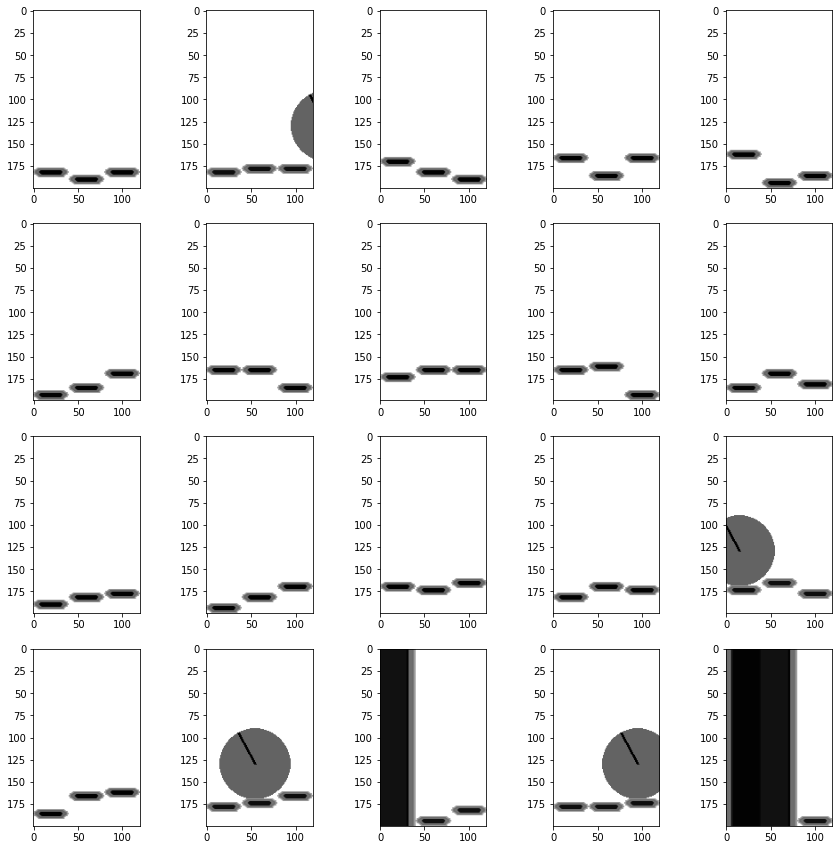

In [3]:
fig, axs = plt.subplots(4, 5, figsize=(15,15))
for i_batch, sample_batched in enumerate(dataloader,0):
    x_, y_ = 0, 0
    for b in sample_batched[0]:
        axs[x_, y_].imshow(b.permute(1, 2, 0), cmap='gray')
        x_ += 1
        if x_ >= 4:
            x_ = 0
            y_ += 1
            
    break

In [4]:
Batch = namedtuple('Batch', ('states', 'actions', 'next_states', 'rewards', 'dones'))

class ReplayBuffer:
    
    def __init__(self, state_size, max_size=10000):
        
        self.max_size = max_size
        self.state_size = state_size
        state_shape =  ((max_size,) + state_size)
        
        self.states = torch.empty(state_shape)
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty(state_shape)
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)
        
        self.idx = 0
        self.size = 0
        
    def add(self, state, action, reward, next_state, done):
        
        self.states[self.idx] = torch.tensor(state)
        self.actions[self.idx] = torch.tensor(action)
        self.rewards[self.idx] = torch.tensor(reward)
        self.next_states[self.idx] = torch.tensor(next_state)
        self.dones[self.idx] = torch.tensor(done)
        
        self.idx = (self.idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
    def sample(self, batch_size):
        
        if self.size <= batch_size:
            sample_indices = np.random.choice(self.size, self.size, replace=False)
        else:
            sample_indices = np.random.choice(self.size, batch_size, replace=False)
        batch = Batch(
                        states = self.states[ sample_indices ,:],
                        actions = self.actions[ sample_indices ,:],
                        rewards = self.rewards[ sample_indices ,:],
                        next_states = self.next_states[ sample_indices ,:],
                        dones = self.dones[ sample_indices ,:]
                    )
        return batch
        
        

In [5]:
# sequential API

env = pistonball_v0.env(local_ratio=.02, continuous=False, random_drop=True,
starting_angular_momentum=True, ball_mass = .75, ball_friction=.3,
ball_elasticity=1.5, max_frames=2000, fullyObservable=False)


In [7]:
observation = env.reset()

In [8]:
memory = ReplayBuffer(state_size=observation.shape)

In [9]:
# erratic

tracker = {}

observation = env.reset()
for agent in env.agent_iter():
    if agent not in tracker:
        tracker[agent] = {"observation": None, "action": None, "next_observation": None}
    reward, done, info = env.last()
    action = env.action_spaces[agent].sample()
    next_observation = env.step(action)
    
    if tracker[agent]["observation"] is not None:
        memory.add(tracker[agent]["observation"], tracker[agent]["action"], reward, tracker[agent]["next_observation"], done)
    
    tracker[agent]["action"] = action
    tracker[agent]["observation"] = observation
    tracker[agent]["next_observation"] = next_observation
    
    
    

In [13]:
# ability to customize the network arch

class DQN(nn.Module):
    
    def __init__(self, state_dim=0, action_dim=0):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.conv1_act = torch.nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.conv2_act = torch.nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(state_dim[-1]))
        convh = conv2d_size_out(conv2d_size_out(state_dim[-2]))
        self.linear_1 = nn.Linear(convw*convh*32, 128)
        self.linear1_act = nn.ReLU()
        self.linear_2 = nn.Linear(128, 128)
        self.linear2_act = nn.ReLU()
        self.softmax = nn.Softmax(3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_act(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.conv2_act(x)
        x = self.bn2(x)
        x = self.linear_1(x)
        x = self.linear1_act(x)
        x = self.linear2(x)
        x = self.linear2_act(x)
        x = self.softmax(x)
        return x
        
        
        

In [14]:
# observation.shape
model = DQN((3, 120, 200))
model

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv1_act): ReLU()
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (conv2_act): ReLU()
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_1): Linear(in_features=40608, out_features=128, bias=True)
  (linear1_act): ReLU()
  (linear_2): Linear(in_features=128, out_features=128, bias=True)
  (linear2_act): ReLU()
  (softmax): Softmax(dim=3)
)

In [ ]:


def train_DQN(model, ):
    